In [1]:
from chordextractor import ChordExtractor
import chordgraph

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.stats import itemfreq
import time
import os
import pickle
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import Lasso, LogisticRegression
%matplotlib inline 

## Functions to get vectors from MIDI files for chords, pitches and durations

In [2]:
# Get file names of type type_ in all the subdirectories of the path
def get_filenames(path, type_ = None):
    if type_ == None:
        return sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), [])
    else:
        return filter(lambda f: f.endswith(type_), sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), []))
       
# Getting set of all possible chords after normalization        
chord_encode =  {k: i for k, i in zip(chordgraph.ChordGraph().normalized_chords,
                                      range(len(chordgraph.ChordGraph().normalized_chords)))}        
        
# Enumerating chords for processing and storage optimization
def encode_chords(chords, encoder = None, type_ = None):
    if type_ == 'chord':
        return map(lambda chord: encoder[chord], chords)
    return chords

# Generate all sequences of 4 consecutive notes
def get_sequences(data):
    return map(lambda i: [data[i], data[i+1], data[i+2], data[i+3]], range(0, len(data)-3))

# Returns index of the note quartet in the vector
def notestoindex(numbers, num):
    return reduce(lambda x, y: num*x+y, numbers)

# Build vector of ocurrences of note quartets
def build_vector(sequence, num):
    vector = [0] * num**4
    seqs_indexed = map(notestoindex, sequence, [num]*len(sequence))
    for x in itemfreq(seqs_indexed):
        vector[x[0]] = x[1]
    return vector

def vector_from_file(filename_):
    extractor = ChordExtractor(filename_)
    chord_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedChords(), chord_encode, 'chord')),14)
    pitch_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedPitches())),12)
    return chord_vector, pitch_vector

#normalizedChords = extractor.getNormalizedChords()
#normalizedPitches = extractor.getNormalizedPitches()
# normalizedDurations = extractor.getChordDurations()

# Build vectors from MIDI files and pickle them
def vectors_from_files(path, class_, count):
    files = map(lambda x: x[0], sorted(map(lambda f: [f, os.stat(f).st_size], get_filenames(path)), 
                                   key = lambda x: x[1]))[:count]
    c = 0
    for name in files:
        try: 
            with open(str(class_)+str(c)+".dat", "wb") as f:
                pickle.dump(vector_from_file(name), f)
                print name+" done"
                print str(class_)+str(c)+".dat"
                c+=1
        except:
            print "Couldn't process " + name + " because Music 21 sucks."
    #X = map(lambda name: vector_from_file(name), files)
    return True

# Loading vectors from pickles
def get_vectors_from_pickles(path):
    class0 = filter(lambda x: x.split('/')[-1][0]=='0', get_filenames(path, ".dat"))
    class1 = filter(lambda x: x.split('/')[-1][0]=='1', get_filenames(path, ".dat"))
    class2 = filter(lambda x: x.split('/')[-1][0]=='2', get_filenames(path, ".dat"))
    class3 = filter(lambda x: x.split('/')[-1][0]=='3', get_filenames(path, ".dat"))
    vector0 = []
    vector1 = []
    vector2 = []
    vector3 = []
    for name in class0:
        with open(name, "rb") as f:
            vector0.append(pickle.load(f))
    for name in class1:
        with open(name, "rb") as f:
            vector1.append(pickle.load(f))
    for name in class2:
        with open(name, "rb") as f:
            vector2.append(pickle.load(f))
    for name in class3:
        with open(name, "rb") as f:
            vector3.append(pickle.load(f))
    return vector0, vector1, vector2, vector3

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Rename files, get vectors

In [3]:
# path_to_class0 = './50s/'
# path_to_class1 = './60s/'
# # Renaming 50s and 60s .kar to .mid
# map1 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
#            get_filenames(path_to_class0))
# map2 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
#            get_filenames(path_to_class1))

# # Identifying the smallest directory in terms of number of midis
# midi_count = min(len(get_filenames(path_to_class0)), len(get_filenames(path_to_class1)))
# midi_count

In [4]:
# start_time = time.time()
# vectors = vectors_from_files(path_to_class0, 3, 72)
# print "Class 3 is done"
# print("--- %s seconds ---" % (time.time() - start_time))
# vectors2 = vectors_from_files(path_to_class1, 2, 76)
# print "Class 2 is done"
# print("--- %s seconds ---" % (time.time() - start_time))

In [5]:
# Extraction of the features with maximal interclass variance
def feature_selector(vectors, percentile_):
    transposed = map(np.transpose, vectors)
    means = map(lambda t: map(np.mean, t), transposed)
    stds = map(lambda x: np.std(x), zip(*means))
    threshold = np.percentile(stds, percentile_)
    stds = zip(range(len(stds)), stds)
    index = map(lambda st: st[0], filter(lambda x: x[1] > threshold, stds))
    new_vectors = map(lambda vector: map(lambda v: map(lambda ind: v[ind], index), vector), vectors)
    return new_vectors

In [6]:
# Separating chords and pitches
vectors = get_vectors_from_pickles('vectors')
chords = map(lambda vector: map(lambda v: v[0], vector), vectors)
pitches = map(lambda vector: map(lambda v: v[1], vector), vectors)

In [7]:
new_chords = feature_selector(chords, 95)
new_pitches = feature_selector(pitches, 95)

# SVM

## Chords

In [8]:
def rotate(list_, count):
    return sum([list_[-count:]]+[list_[:-count]], [])

In [58]:
# Building train, validation and test sets for each class
X_chord = sum(map(lambda c: [new_chords[0][c], new_chords[1][c], new_chords[2][c], new_chords[3][c]],
            range(len(new_chords[0]))), [])
X_pitch = sum(map(lambda c: [new_pitches[0][c], new_pitches[1][c], new_pitches[2][c], new_pitches[3][c]],
            range(len(new_pitches[0]))), [])
Y = [[0]*72, [1]*72, [2]*72, [3]*72]
Y = sum(map(lambda y: [Y[0][y], Y[1][y], Y[2][y], Y[3][y]], range(len(Y[0]))), [])

In [80]:
# Function to train SVM on training set and to predict the validation set
def trainpredict(degree, C, gamma):
    clf = svm.SVC(kernel = 'rbf', degree = degree, C = C,  
                  shrinking=False, gamma = gamma) 
    clf.fit(X_train, Y_train)
    return (Y_valid == clf.predict(X_valid)).sum()*100/len(Y_valid), degree, C, gamma

# Function to fit poly SVMs of degrees 3 to 5 each with Cs and gammas from the given range
def fitDegree_C():
    return map(lambda gamma: map(lambda degree: map(trainpredict, [degree]*6,
                            map(lambda c: math.exp(c), np.linspace(-1, 2*degree, 6)),
                            [gamma]*6), range(5, 6)), 
               map(lambda x: 1.0e-06+0.55e-05*x, range(200)))

In [87]:
# Chords
X_chord_ = X_chord
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_chord)*0.1)
    valid = int(len(X_chord)*0.1)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_chord_[-test:]
    X_valid = X_chord_[-valid:-test]
    X_train = X_chord_[:-valid]
    fit_ = fitDegree_C()
    best_fit = max(enumerate(sum(sum(fit_, []), [])), key = lambda x: x[1])
    best_fits.append(best_fit)
    clf = svm.SVC(kernel = 'rbf', degree = best_fit[1][1], C=best_fit[1][-2], gamma = best_fit[1][-1],
                  shrinking=False)
    clf.fit(X_train, Y_train)
    Y_predict.append(clf.predict(X_test))
    Y_original.append(Y_test)
    
    X_chord_ = rotate(X_chord_, int(len(X_chord_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0
Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [88]:
best_fits

[(365, (75, 5, 22026.465794806718, 0.000331)),
 (869, (82, 5, 22026.465794806718, 0.000793)),
 (287, (75, 5, 22026.465794806718, 0.0002595)),
 (161, (71, 5, 22026.465794806718, 0.000144)),
 (377, (71, 5, 22026.465794806718, 0.000342)),
 (1199, (67, 5, 22026.465794806718, 0.0010955)),
 (65, (64, 5, 22026.465794806718, 5.599999999999999e-05)),
 (1097, (67, 5, 22026.465794806718, 0.0010019999999999999)),
 (329, (67, 5, 22026.465794806718, 0.00029800000000000003)),
 (61, (75, 5, 3.320116922736548, 5.599999999999999e-05))]

In [89]:
Y_predict_chord = np.asarray(sum(map(lambda y: list(y), Y_predict), []))
Y_origin_chord = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [90]:
print "We predict the {} percent of test data".format((Y_origin_chord==Y_predict_chord).sum()*100/len(Y_origin_chord))

We predict the 67 percent of test data


In [91]:
#rbf degree 5 0.15 valid 76%
#zip(Y_predict_chord, Y_origin_chord)

Confusion matrix, without normalization


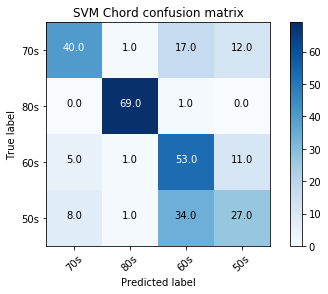

In [92]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), 
                      classes=['70s', '80s', '60s', '50s'], normalize=False,
                      title='SVM Chord confusion matrix')

Normalized confusion matrix


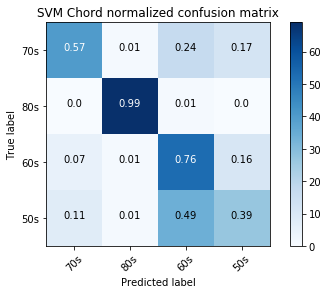

In [93]:
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), 
                      classes=['70s', '80s', '60s', '50s'], normalize=True,
                      title='SVM Chord normalized confusion matrix')

# SVM 

## Pitches

In [94]:
# Chords
X_pitch_ = X_pitch
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_pitch)*0.1)
    valid = int(len(X_pitch)*0.1)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_pitch_[-test:]
    X_valid = X_pitch_[-valid:-test]
    X_train = X_pitch_[:-valid]
    fit_ = fitDegree_C()
    best_fit = max(enumerate(sum(sum(fit_, []), [])), key = lambda x: x[1])
    best_fits.append(best_fit)
    clf = svm.SVC(kernel = 'rbf', degree = best_fit[1][1], C=best_fit[1][-2], gamma = best_fit[1][-1],
                  shrinking=False)
    clf.fit(X_train, Y_train)
    Y_predict.append(clf.predict(X_test))
    Y_original.append(Y_test)
    
    X_pitch_ = rotate(X_pitch_, int(len(X_pitch_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0
Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [95]:
Y_predict_pitch = np.asarray(sum(map(lambda y: list(y), Y_predict), []))
Y_origin_pitch = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [96]:
print "We predict the {} percent of test data".format((Y_origin_pitch==Y_predict_pitch).sum()*100/len(Y_origin_pitch))

We predict the 64 percent of test data


In [97]:
best_fits

[(539, (67, 5, 22026.465794806718, 0.0004905)),
 (1199, (71, 5, 22026.465794806718, 0.0010955)),
 (19, (82, 5, 3.320116922736548, 1.7500000000000002e-05)),
 (797, (64, 5, 22026.465794806718, 0.000727)),
 (101, (75, 5, 22026.465794806718, 8.9e-05)),
 (95, (67, 5, 22026.465794806718, 8.35e-05)),
 (17, (78, 5, 22026.465794806718, 1.2e-05)),
 (59, (64, 5, 22026.465794806718, 5.0499999999999994e-05)),
 (35, (64, 5, 22026.465794806718, 2.8499999999999998e-05)),
 (95, (75, 5, 22026.465794806718, 8.35e-05))]

Confusion matrix, without normalization


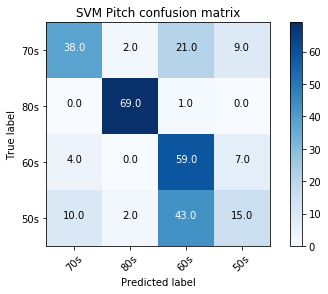

In [98]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), 
                      classes=['70s', '80s', '60s', '50s'], normalize=False,
                      title='SVM Pitch confusion matrix')

Normalized confusion matrix


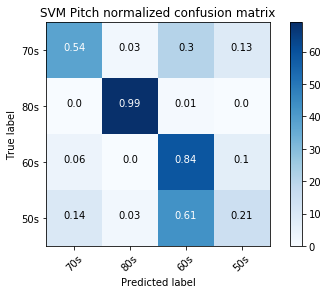

In [99]:
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), 
                      classes=['70s', '80s', '60s', '50s'], normalize=True,
                      title='SVM Pitch normalized confusion matrix')

# Penalized Logistic Regression

## Chords

In [100]:
# Fitting the parameter alpha for the LASSO model on the training / validation
# Function to train LASSO on training set and to predict the validation set
def trainpredict_L(C):
    logreg = LogisticRegression(C = C, solver = 'newton-cg', multi_class='multinomial')
    logreg.fit(X_train, Y_train)
    Y_predict = logreg.predict(X_valid)
    return (Y_valid == Y_predict).sum()*100/len(Y_valid), C

# Function to fit alpha for LASSO
def fitC():
    return map(lambda C: trainpredict_L(np.e**C), np.linspace(-12, 1000, 300))

In [110]:
# Chords
X_chord_ = X_chord
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_pitch)*0.1)
    valid = int(len(X_pitch)*0.15)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_chord_[-test:]
    X_valid = X_chord_[-valid:-test]
    X_train = X_chord_[:-valid]
    fit_ = fitC()
    best_fit = max(enumerate(fit_), key = lambda x: x[1])
    best_fits.append(best_fit)
    logreg = LogisticRegression(C = best_fit[1][-1], solver = 'newton-cg', multi_class='multinomial')
    logreg.fit(X_train, Y_train)
    Y_predict.append(logreg.predict(X_test))
    Y_original.append(Y_test)
    X_chord_ = rotate(X_chord_, int(len(X_chord_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0


/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in double_scalars


Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [111]:
Y_predict_chord = np.asarray(sum(map(lambda y: list(y), Y_predict), []))
Y_origin_chord = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [113]:
print "We predict the {} percent of test data".format((Y_origin_chord==Y_predict_chord).sum()*100/len(Y_origin_chord))

We predict the 60 percent of test data


In [114]:
best_fits

[(6, (62, 4054.9446137122827)),
 (7, (62, 119647.79833715739)),
 (5, (62, 137.4248088873355)),
 (6, (67, 4054.9446137122827)),
 (11, (65, 90695105660.905441)),
 (2, (65, 0.0053494087897504239)),
 (5, (62, 137.4248088873355)),
 (6, (60, 4054.9446137122827)),
 (1, (72, 0.00018129507320660182)),
 (3, (62, 0.15784308913485159))]

Confusion matrix, without normalization


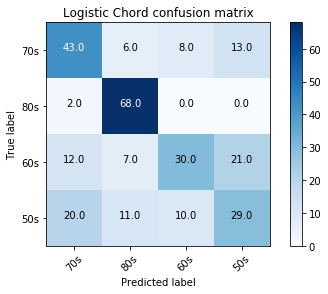

In [115]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), 
                      classes=['70s', '80s', '60s', '50s'], normalize=False,
                      title='Logistic Chord confusion matrix')

Normalized confusion matrix


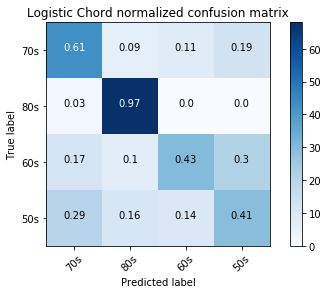

In [116]:
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), 
                      classes=['70s', '80s', '60s', '50s'], normalize=True,
                      title='Logistic Chord normalized confusion matrix')

# Linear Regression LASSO

## Pithces

In [117]:
# Chords
X_pitch_ = X_pitch
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_pitch)*0.1)
    valid = int(len(X_pitch)*0.15)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_pitch_[-test:]
    X_valid = X_pitch_[-valid:-test]
    X_train = X_pitch_[:-valid]
    fit_ = fitC()
    best_fit = max(enumerate(fit_), key = lambda x: x[1])
    best_fits.append(best_fit)
    logreg = LogisticRegression(C = best_fit[1][-1], solver = 'newton-cg', multi_class='multinomial')
    logreg.fit(X_train, Y_train)
    Y_predict.append(logreg.predict(X_test))
    Y_original.append(Y_test)
    X_pitch_ = rotate(X_pitch_, int(len(X_pitch_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0


/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in double_scalars


Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [118]:
Y_predict_chord = np.asarray(sum(map(lambda y: list(y), Y_predict), []))
Y_origin_chord = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [119]:
print "We predict the {} percent of test data".format((Y_origin_chord==Y_predict_chord).sum()*100/len(Y_origin_chord))

We predict the 55 percent of test data


In [120]:
best_fits

[(5, (65, 137.4248088873355)),
 (4, (58, 4.6574194956589041)),
 (1, (62, 0.00018129507320660182)),
 (2, (58, 0.0053494087897504239)),
 (214, (51, inf)),
 (3, (62, 0.15784308913485159)),
 (6, (67, 4054.9446137122827)),
 (2, (58, 0.0053494087897504239)),
 (1, (60, 0.00018129507320660182)),
 (2, (65, 0.0053494087897504239))]

Confusion matrix, without normalization


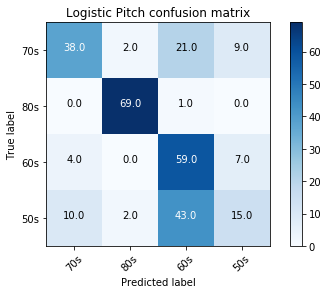

In [121]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), 
                      classes=['70s', '80s', '60s', '50s'], normalize=False,
                      title='Logistic Pitch confusion matrix')

Normalized confusion matrix


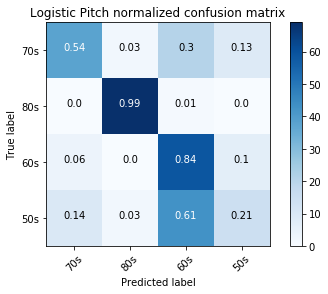

In [122]:
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), 
                      classes=['70s', '80s', '60s', '50s'], normalize=True,
                      title='Logistic Pitch normalized confusion matrix')